# 目次

- データ確認
- 外れ値確認
- 学習
- 相関分析
- 主成分分析
- （再）学習

# ライブラリ群

In [187]:
# データ処理
import csv
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.options.display.float_format = '{:.0f}'.format
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# データ分割
from sklearn.model_selection import train_test_split

# アルゴリズム
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression # 線形回帰
from sklearn.svm import SVC # サポートベクトルマシン
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.linear_model import LogisticRegressionCV # ロジスティック回帰`
from sklearn.linear_model import SGDClassifier # 確率的勾配降下法

from sklearn.cluster import KMeans # k-means
from sklearn.neighbors import KNeighborsClassifier # K近傍法（分類）
from sklearn.neighbors import KNeighborsRegressor # K近傍法（回帰）
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
import xgboost as xgb # XGBoost
import lightgbm as lgb # LightGBM
# from sklearn.linear_model import Perceptron # パーセプトロン
# from sklearn.naive_bayes import GaussianNB # ナイーブベイズ分類器

# 評価
from sklearn.metrics import confusion_matrix # 混同行列
from sklearn.model_selection import learning_curve # 学習曲線
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score # 各評価指標
from sklearn import metrics
from sklearn.metrics import roc_auc_score # AUC

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP'] # 日本語対応
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# データ確認

In [122]:
breast_cancer = pd.read_csv("./breast_cancer_diagnostic.csv", sep=',')

In [123]:
breast_cancer.head()

,ID,診断,半径-平均,テクスチャ-平均,周長-平均,面積-平均,滑らかさ-平均,コンパクトさ-平均,凹面-平均,凹点-平均,...,最悪の半径,最悪のテクスチャ,最悪の境界,最悪のエリア,最悪の滑らかさ,最悪のコンパクトさ,最悪の凹面,最悪の凹点,対称性最悪,最悪のフラクタル次元
0,842302,M,18,10,123,1001,0,0,0,0,...,25,17,185,2019,0,1,1,0,0,0
1,842517,M,21,18,133,1326,0,0,0,0,...,25,23,159,1956,0,0,0,0,0,0
2,84300903,M,20,21,130,1203,0,0,0,0,...,24,26,152,1709,0,0,0,0,0,0
3,84348301,M,11,20,78,386,0,0,0,0,...,15,26,99,568,0,1,1,0,1,0
4,84358402,M,20,14,135,1297,0,0,0,0,...,23,17,152,1575,0,0,0,0,0,0


In [124]:
breast_cancer.shape

(569, 32)

In [125]:
# 欠損値
missing_values = pd.DataFrame()
for column in breast_cancer.columns:
    missing_values[column] = [breast_cancer[breast_cancer[column].isnull()].shape[0]]
missing_values.T

,0
ID,0
診断,0
半径-平均,0
テクスチャ-平均,0
周長-平均,0
面積-平均,0
滑らかさ-平均,0
コンパクトさ-平均,0
凹面-平均,0
凹点-平均,0


In [126]:
duplicated = pd.DataFrame()
duplicated["重複行数"] = [breast_cancer[breast_cancer.duplicated()].shape[0]]
duplicated

,重複行数
0,0


In [326]:
# 目的変数の確認（正例、負例件数）
breast_cancer['診断'].value_counts()

0    357
1    212
Name: 診断, dtype: int64

乳房組織の診断（M =悪性、B =良性）  
「M =悪性」を正例、「B =良性」を負例とし、「悪性」を予測する  

In [128]:
# 目的変数の数値化
breast_cancer['診断'] = breast_cancer['診断'].apply(lambda x: 1 if x == 'M' else 0)

value_counts = breast_cancer['診断'].value_counts()
taget = breast_cancer['診断']

df = pd.DataFrame()
df['ラベル'] = value_counts.index
df['件数'] = value_counts.values
ratio=[]
ratio.append((value_counts.values[0] / len(taget) * 100).round(decimals=2).astype('str'))
ratio.append((value_counts.values[1] / len(taget) * 100).round(decimals=2).astype('str'))
df['割合'] = [f'{ratio[0]}%', f'{ratio[1]}%']
print(f"全レコード数：{len(taget)}")
df

全レコード数：569


,ラベル,件数,割合
0,0,357,62.74%
1,1,212,37.26%


データ件数は少ないものの、正例・負例の件数に偏りはなく均衡データである。

# 外れ値確認

## 外れ値検出

In [129]:
plt.rcParams["figure.figsize"] = [10,2] # 表示サイズ

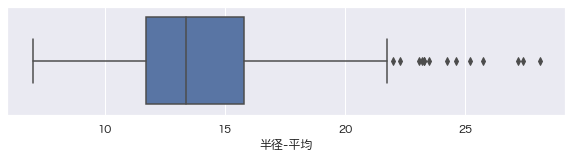

In [130]:
plt.grid()
sns.boxplot(x='半径-平均', data=breast_cancer);

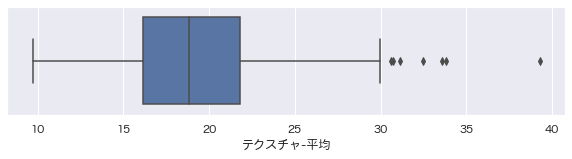

In [131]:
plt.grid()
sns.boxplot(x='テクスチャ-平均', data=breast_cancer);

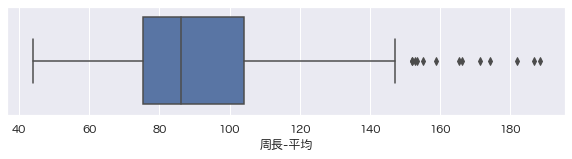

In [132]:
plt.grid()
sns.boxplot(x='周長-平均', data=breast_cancer);

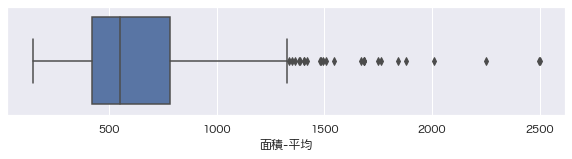

In [133]:
plt.grid()
sns.boxplot(x='面積-平均', data=breast_cancer);

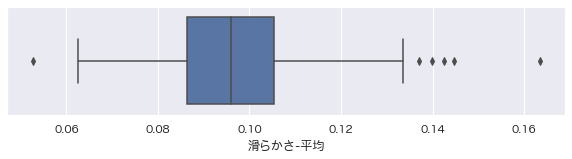

In [134]:
plt.grid()
sns.boxplot(x='滑らかさ-平均', data=breast_cancer);

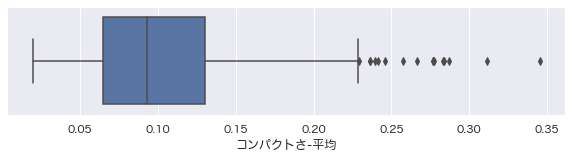

In [135]:
plt.grid()
sns.boxplot(x='コンパクトさ-平均', data=breast_cancer);

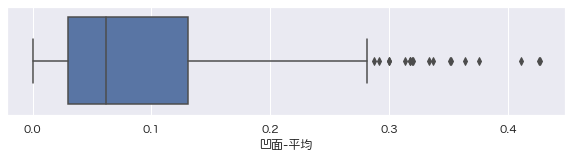

In [136]:
plt.grid()
sns.boxplot(x='凹面-平均', data=breast_cancer);

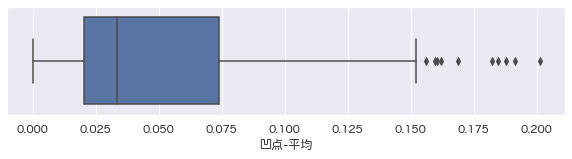

In [137]:
plt.grid()
sns.boxplot(x='凹点-平均', data=breast_cancer);

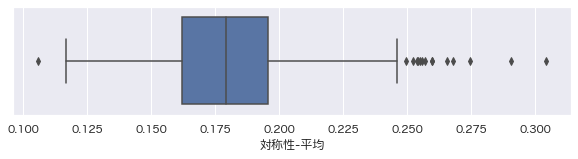

In [138]:
plt.grid()
sns.boxplot(x='対称性-平均', data=breast_cancer);

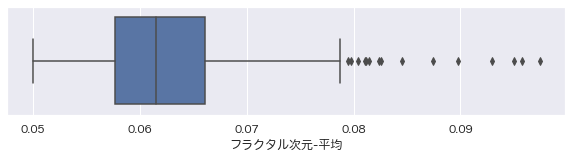

In [139]:
plt.grid()
sns.boxplot(x='フラクタル次元-平均', data=breast_cancer);

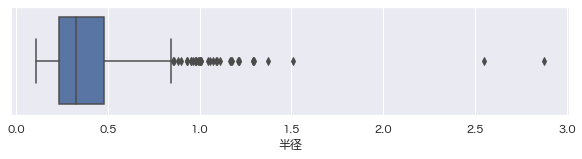

In [140]:
plt.grid()
sns.boxplot(x='半径', data=breast_cancer);

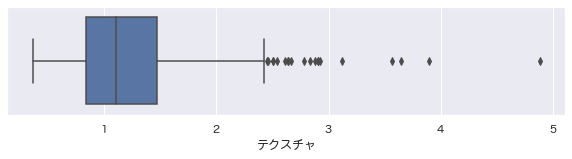

In [141]:
plt.grid()
sns.boxplot(x='テクスチャ', data=breast_cancer);

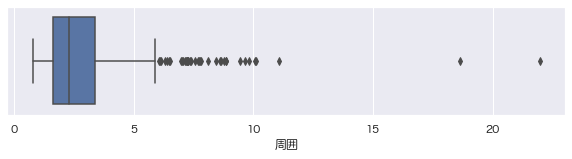

In [142]:
plt.grid()
sns.boxplot(x='周囲', data=breast_cancer);

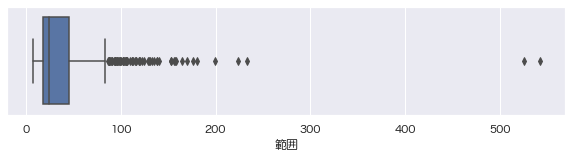

In [143]:
plt.grid()
sns.boxplot(x='範囲', data=breast_cancer);

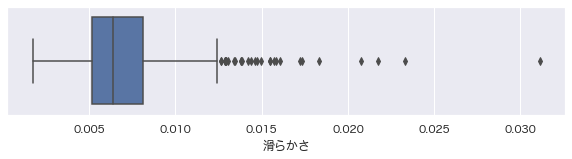

In [144]:
plt.grid()
sns.boxplot(x='滑らかさ', data=breast_cancer);

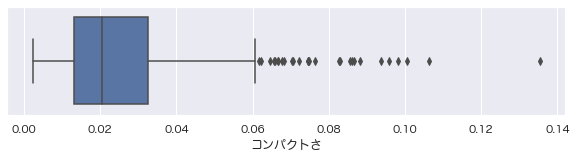

In [145]:
plt.grid()
sns.boxplot(x='コンパクトさ', data=breast_cancer);

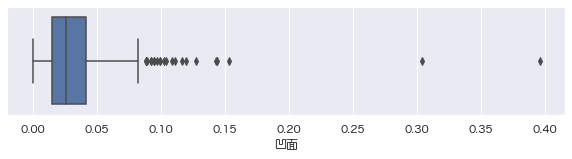

In [146]:
plt.grid()
sns.boxplot(x='凹面', data=breast_cancer);

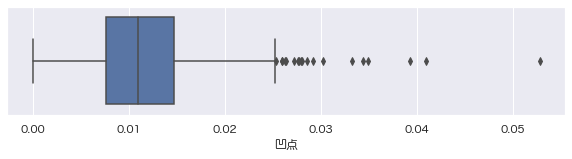

In [147]:
plt.grid()
sns.boxplot(x='凹点', data=breast_cancer);

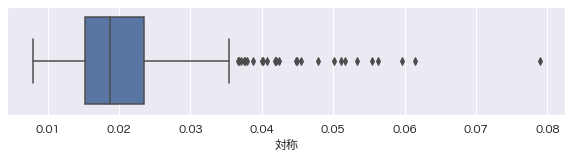

In [148]:
plt.grid()
sns.boxplot(x='対称', data=breast_cancer);

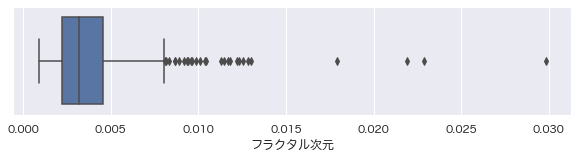

In [149]:
plt.grid()
sns.boxplot(x='フラクタル次元', data=breast_cancer);

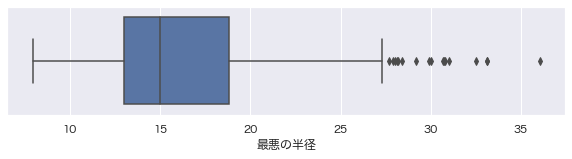

In [150]:
plt.grid()
sns.boxplot(x='最悪の半径', data=breast_cancer);

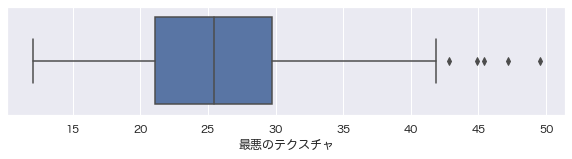

In [151]:
plt.grid()
sns.boxplot(x='最悪のテクスチャ', data=breast_cancer);

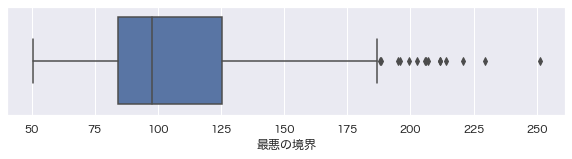

In [152]:
plt.grid()
sns.boxplot(x='最悪の境界', data=breast_cancer);

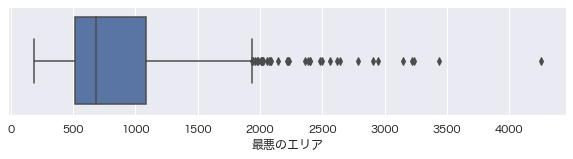

In [153]:
plt.grid()
sns.boxplot(x='最悪のエリア', data=breast_cancer);

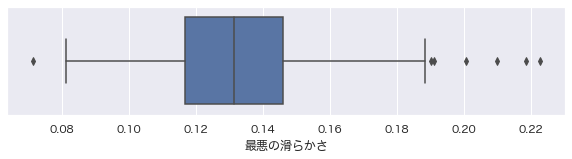

In [154]:
plt.grid()
sns.boxplot(x='最悪の滑らかさ', data=breast_cancer);

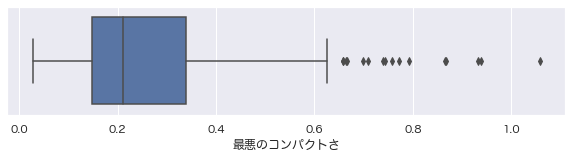

In [155]:
plt.grid()
sns.boxplot(x='最悪のコンパクトさ', data=breast_cancer);

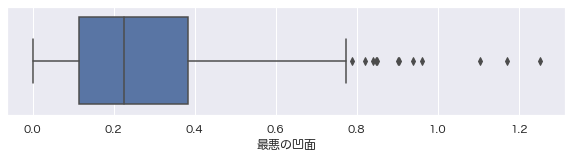

In [156]:
plt.grid()
sns.boxplot(x='最悪の凹面', data=breast_cancer);

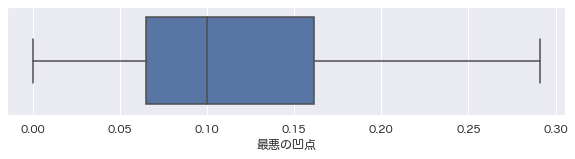

In [157]:
plt.grid()
sns.boxplot(x='最悪の凹点', data=breast_cancer);

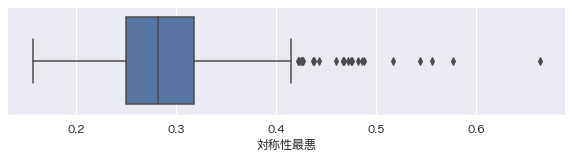

In [158]:
plt.grid()
sns.boxplot(x='対称性最悪', data=breast_cancer);

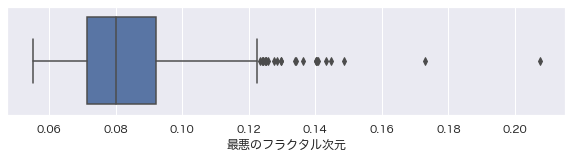

In [159]:
plt.grid()
sns.boxplot(x='最悪のフラクタル次元', data=breast_cancer);

ほとんどの項目に外れ値が含まれている。  
念の為、外れ値検定を実施する。

## 外れ値検定

In [160]:
# スミルノフ=グラブス検定
def missing_test(target_data):
    data = target_data
    alpha = 0.5

    x, o = list(data), []
    while True:
        n = len(x)
        t = stats.t.isf(q=(alpha / n) / 2, df=n - 2)
        tau = (n - 1) * t / np.sqrt(n * (n - 2) + n * t * t)
        i_min, i_max = np.argmin(x), np.argmax(x)
        myu, std = np.mean(x), np.std(x, ddof=1)
        i_far = i_max if np.abs(x[i_max] - myu) > np.abs(x[i_min] - myu) else i_min
        tau_far = np.abs((x[i_far] - myu) / std)
        if tau_far < tau: break
        o.append(x.pop(i_far))

    not_out = np.array(x)
    out = np.array(o)
    out.astype('int').tolist()
    print(out)

In [161]:
missing_test(breast_cancer['半径'])

[2.873 2.547 1.509 1.37  1.296 1.292 1.291 1.215 1.214 1.207 1.176 1.172
 1.167 1.111 1.095 1.088 1.072 1.058 1.046]


In [162]:
missing_test(breast_cancer['テクスチャ'])

[4.885 3.896 3.647 3.568 3.12  2.927 2.91  2.904 2.878 2.836 2.777]


In [163]:
missing_test(breast_cancer['テクスチャ-平均'])

[39.28 33.81 33.56]


In [164]:
missing_test(breast_cancer['周囲'])

[21.98  18.65  11.07  10.12  10.05   9.807  9.635  9.424  8.867  8.83
  8.758  8.649  8.589  8.419  8.077  7.804  7.749  7.733  7.673  7.561
  7.382  7.337  7.276  7.247  7.237  7.222  7.158  7.128  7.05   7.029
  6.971  6.487  6.462]


In [165]:
missing_test(breast_cancer['範囲'])

[542.2 525.6 233.  224.1 199.7 180.2 176.5 170.  164.1 158.7 156.8 155.8
 153.4 153.1 139.9 138.5 137.9 134.8 133.  130.8 130.2 128.7 124.4 122.3
 120.  119.3 118.8 116.4 116.2 115.2 112.4 111.7 111.4 109.9]


In [166]:
missing_test(breast_cancer['滑らかさ'])

[0.03113 0.02333 0.02177 0.02075 0.01835 0.01736 0.01721 0.01604 0.01582
 0.01574 0.01547 0.01546 0.01496 0.01474 0.01459 0.01439]


In [167]:
missing_test(breast_cancer['コンパクトさ'])

[0.1354  0.1064  0.1006  0.09806 0.09586 0.09368 0.08808 0.08668 0.08606
 0.08555 0.08297 0.08262 0.07643 0.07471 0.07458 0.07446 0.07217 0.07056
 0.07025]


In [168]:
missing_test(breast_cancer['凹面'])

[0.396   0.3038  0.1535  0.1438  0.1435  0.1278  0.1197  0.1166  0.1114
 0.1091  0.104   0.1027  0.0996  0.09953 0.09723 0.09518 0.09472 0.09263
 0.09252 0.08958 0.0889  0.0888 ]


やはり多くの項目に外れ値が含まれていそうである。  
一旦このまま学習を進めて、（必要に応じて）項目別に異常値の確認や、対応方法を検討する。

# 学習

In [169]:
# 混同行列
def show_confusion_matrix(predict, y_test):
    pred =  np.where(predict > 0.5, 1, 0)
    cm = confusion_matrix(y_test, pred)
    matrix = pd.DataFrame(cm)
    matrix.columns = [['予測_負例(0)', '予測_正例(1)']]
    matrix.index = [['実際_負例(0)', '実際_正例(1)']]
    return matrix

In [317]:
# 目的変数の抽出、データ分割
X = breast_cancer.drop('診断', axis=1)
y = breast_cancer['診断']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ロジスティック回帰
logistic = LogisticRegressionCV(max_iter=1000, random_state=42)
logistic.fit(X_train_scaled, y_train)

# 検証、評価
print('訓練スコア: {:.3f}'.format(logistic.score(X_train_scaled, y_train)))
print('テストスコア: {:.3f}'.format(logistic.score(X_test_scaled, y_test)))

# 混同行列
y_pred = logistic.predict(X_test_scaled)
matrix = show_confusion_matrix(y_pred, y_test)
matrix

LogisticRegressionCV(max_iter=1000, random_state=42)

訓練スコア: 0.985
テストスコア: 0.978


,予測_負例(0),予測_正例(1)
実際_負例(0),144,1
実際_正例(1),4,79


## 学習曲線

In [318]:
# 学習曲線
def plot_learning_curve(model, X_data, y_data):
    # データ準備
    train_sizes, train_scores, val_scores = learning_curve(model, X=X_data, y=y_data, train_sizes = np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.figure(figsize=[10,5])
    plt.title("学習曲線")
    plt.xlabel("訓練サイズ")
    plt.ylabel("スコア")

    # 訓練スコア と 検証スコア をプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="訓練スコア")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="検証スコア")

    # 標準偏差の範囲を色付け
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="g", alpha=0.2)

    # Y軸の範囲
    plt.ylim(0.8, 1.0)

    # 凡例の表示位置
    plt.grid()
    plt.legend(loc="best")
    plt.show();

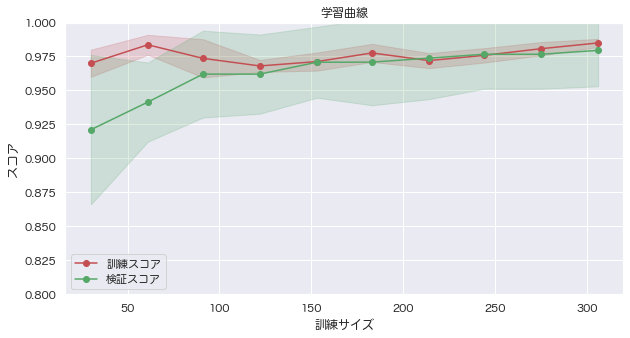

In [319]:
plot_learning_curve(logistic, X_train_scaled, y_train)

スコアが収束していってはいるが、検証スコアが訓練スコアに近づき過ぎている。  
サンプル数が少なく、学習データとテストデータの間に差がないためか。

# 相関分析

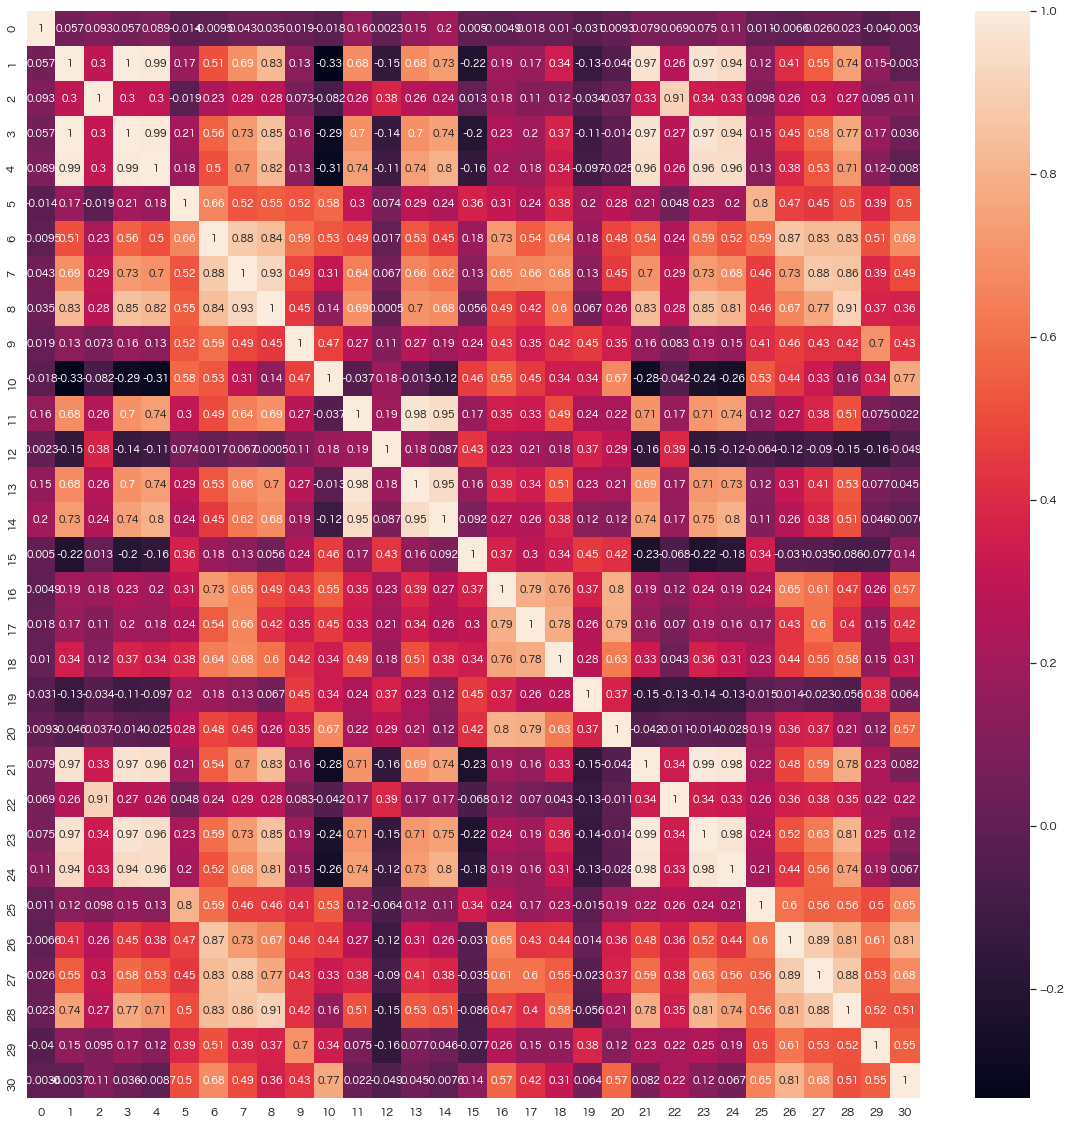

In [ ]:
# ヒートマップ
plt.figure(figsize=(20, 20))
sns.heatmap(pd.DataFrame(X_train_scaled).corr(), annot=True);

変数間の相関が高い項目が多いことがわかる。  
相関係数が0.8以上のもが点在している。    

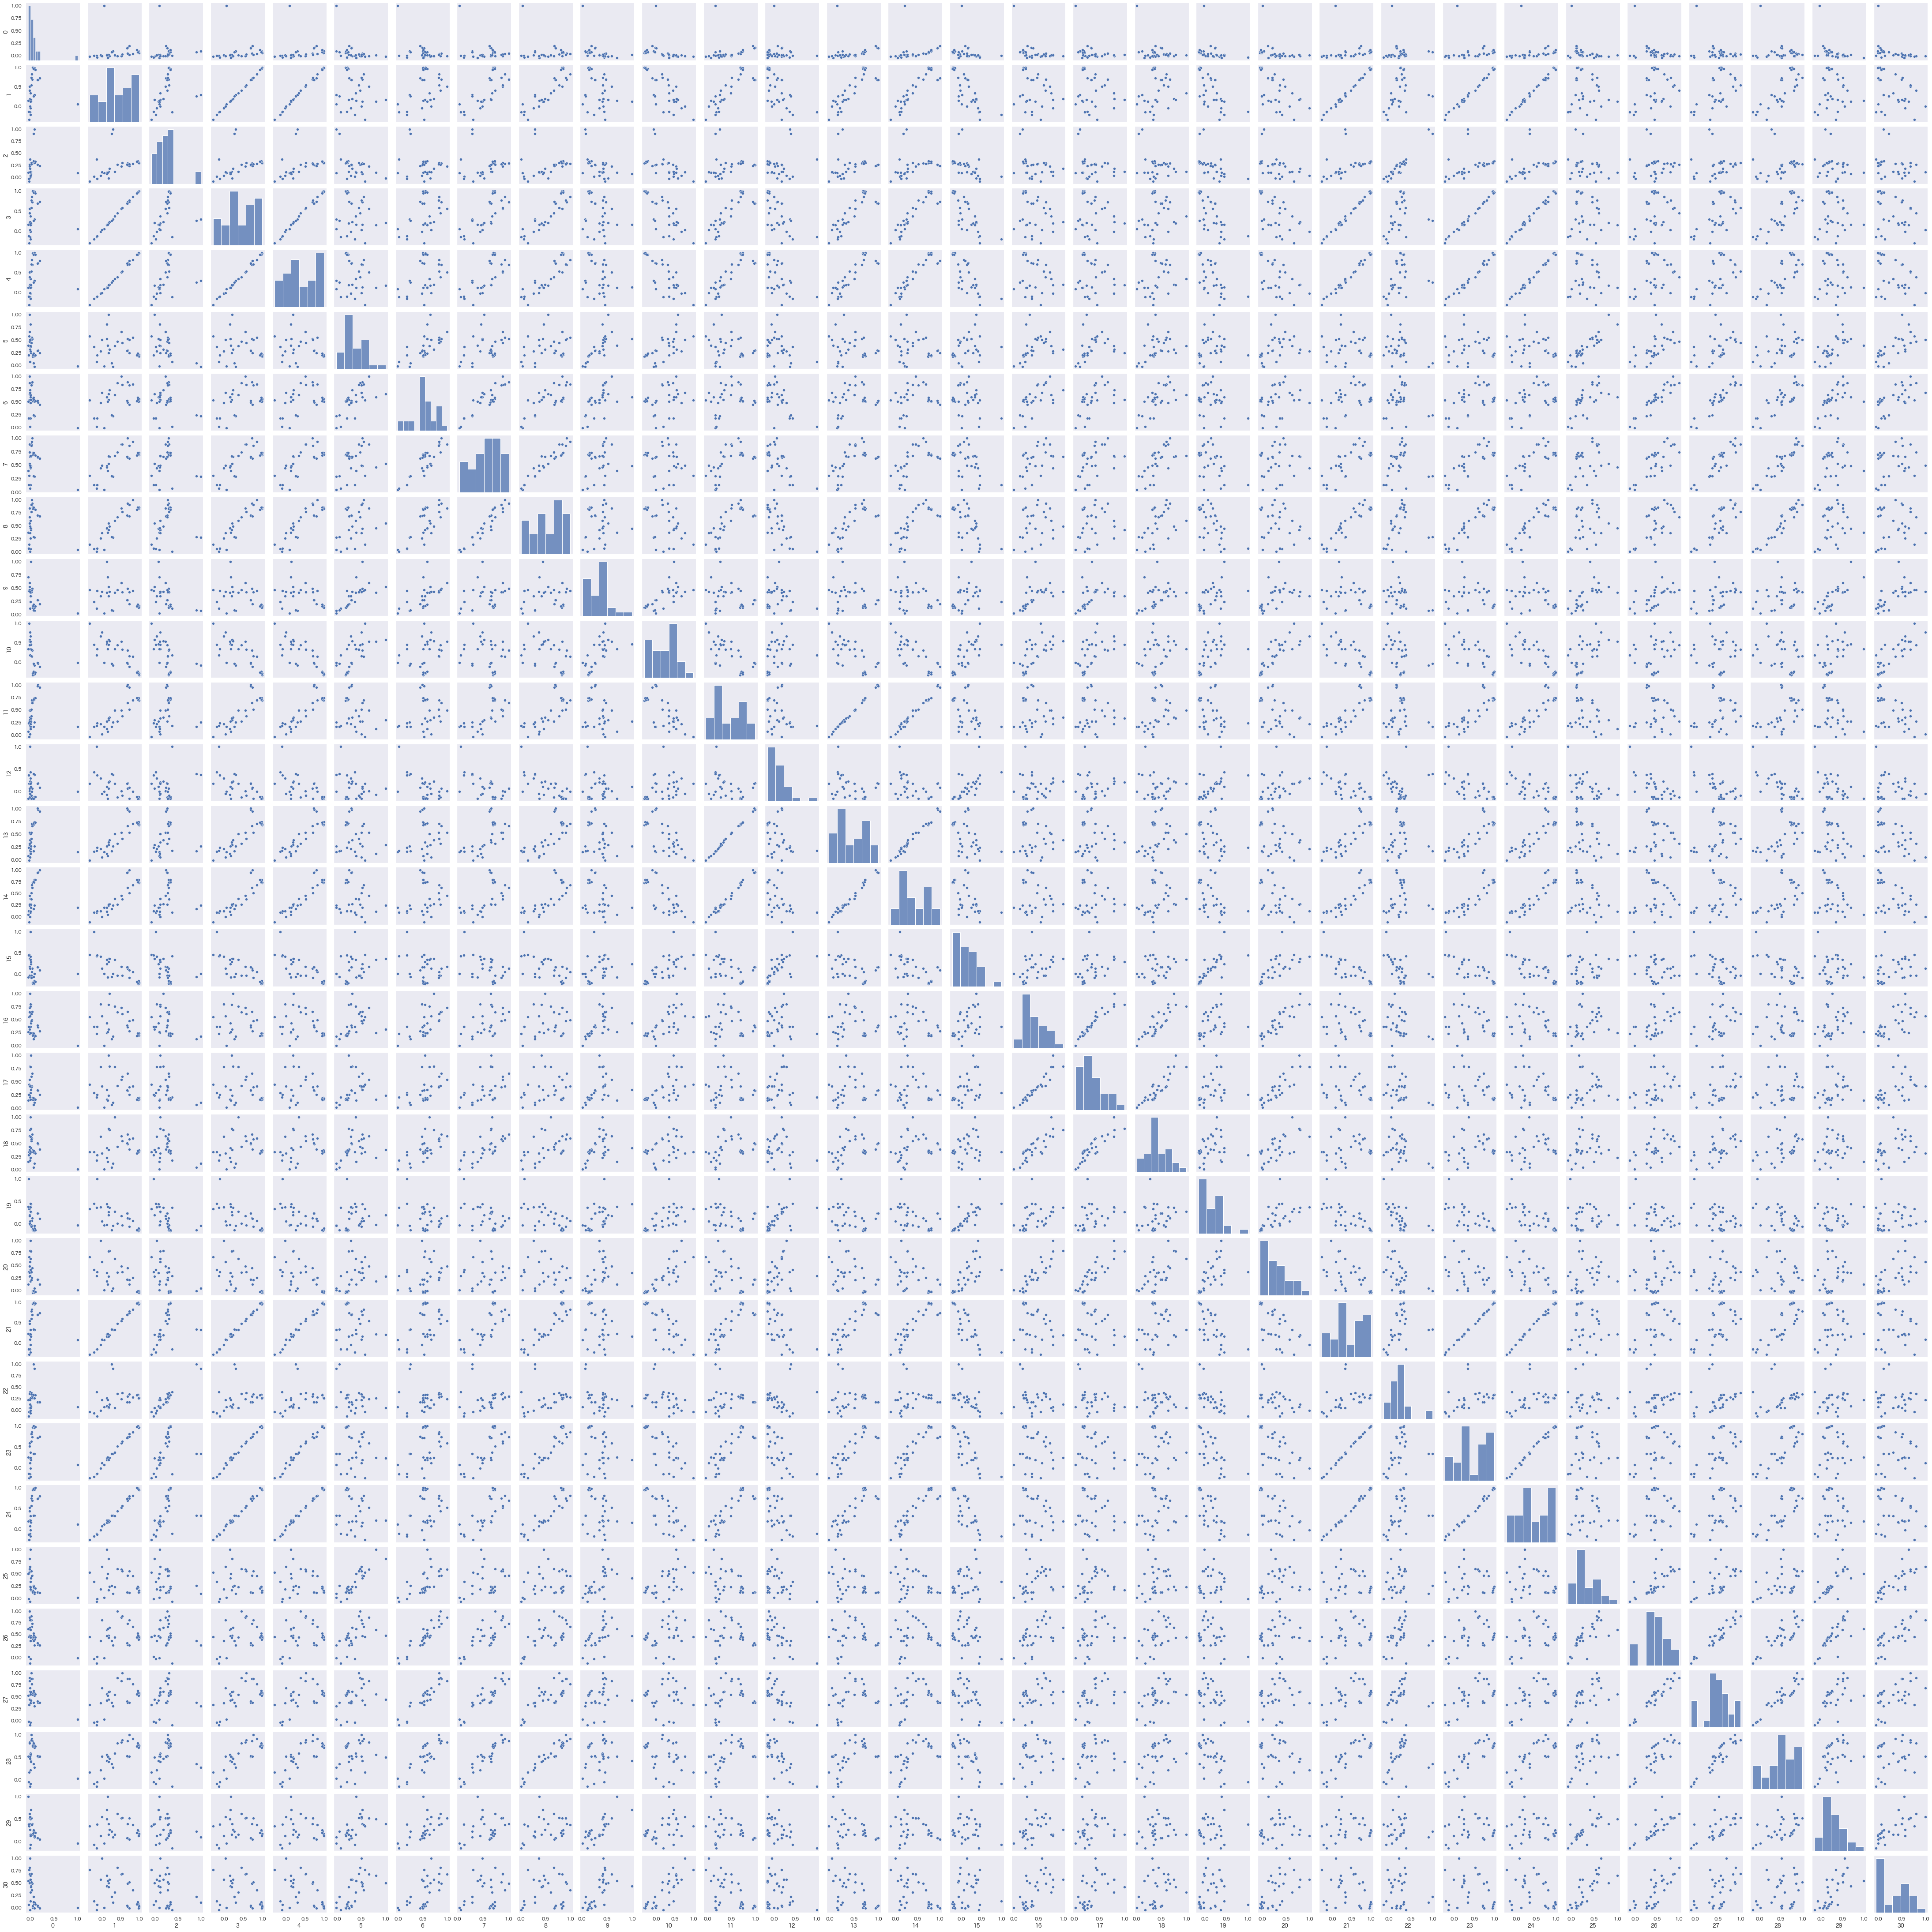

In [53]:
sns.pairplot(pd.DataFrame(X_train_scaled).corr(), height=2);

相関係数が信じられるかの確認  
線形関係の変数がちらほらと見られる。  
一般線形モデルを用いる想定の為、多重共線性の危惧する必要があると思われる。  

In [54]:
# 多重共線性の確認
# VIF（Variance Inflation Factor：　分散拡大係数）
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["特徴量"] = X.columns
 
vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,特徴量
1,63309,半径-平均
3,58124,周長-平均
21,9678,最悪の半径
23,4488,最悪の境界
4,1287,面積-平均
24,1139,最悪のエリア
10,630,フラクタル次元-平均
30,423,最悪のフラクタル次元
5,394,滑らかさ-平均
25,376,最悪の滑らかさ


VIF統計量が10以上の特徴量がほとんどである。多重共線性によるオーバーフィットを危惧することとする。  

In [115]:
from sklearn.linear_model import Ridge # リッジ回帰
from sklearn.metrics import r2_score # R2

# 各変数を他の変数で線形回帰させ、決定係数が1に近い場合は、多重共線性ありと判断する関数
def collinearity_check(Xc, model=None, alpha=1.0, emph=False):    
    if model is None:
        model = Ridge(alpha=alpha)

    m, n = Xc.shape
    if n < 2:
        raise ValueError()

    rc = np.empty((n, n)) # 回帰係数
    scores = np.empty(n) # R2スコア

    X = np.copy(Xc)
    for i in range(n):
        y = np.copy(X[:,i]) # 他の変数で回帰させる
        X[:,i] = 1 # 多重共線性の定数項に対応させる

        model.fit(X, y)
        y_calc = model.predict(X)

        score = r2_score(y, y_calc)
        if score < 0:
            # R2 スコアが 0 以下なら線形性なしとみなす
            scores[i] = 0
            rc[i] = 0
        else:
            scores[i] = score
            if emph:
                # 係数が大きくても R2 スコアが 0 以上の場合は、回帰係数を 0 に加工（線形性なし）
                rc[i] = model.coef_ * score
            else:
                rc[i] = model.coef_

        X[:,i] = y
    
    return rc, scores

In [116]:
Xsc = StandardScaler().fit_transform(X)
cc, cc_scores = collinearity_check(Xsc, emph=True)

<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

Text(66.5, 0.5, 'target variable')

Text(0.5, 48.5, 'used variables to explain the target')

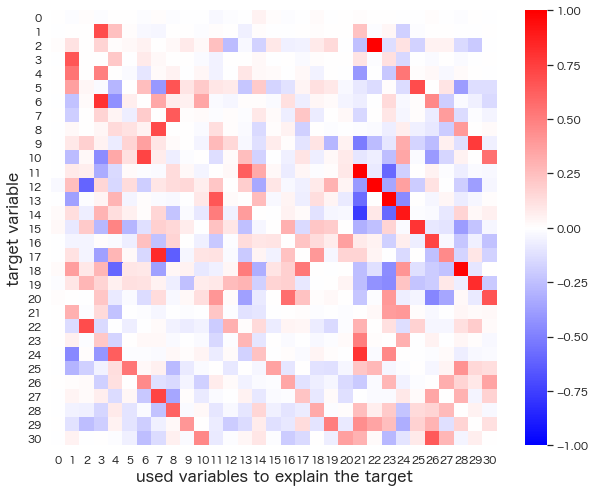

In [118]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(cc), vmin=-1, vmax=1, cmap='bwr', cbar=True)
plt.ylabel('target variable', fontsize=16)
plt.xlabel('used variables to explain the target', fontsize=16)
plt.show();

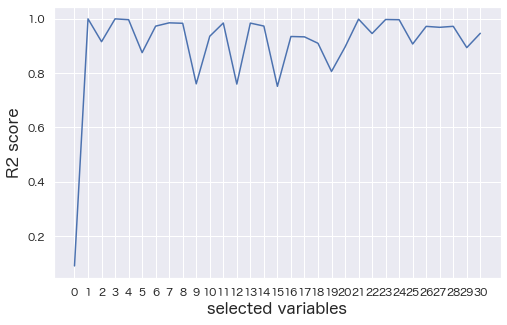

In [120]:
plt.figure(figsize=(8,5))
plt.plot(cc_scores)
plt.grid()
plt.xticks(np.arange(0, len(cc_scores), 1))
plt.ylabel('R2 score', fontsize=16)
plt.xlabel('selected variables', fontsize=16)
plt.show();

R２スコアが1に近ければ、多重共線性の可能性が高いとみなす。  
多重共線性ありと思われる。

# 主成分分析

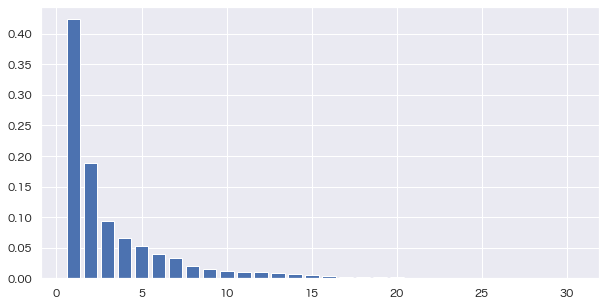

In [55]:
# 寄与率
pca = PCA(n_components=30)
pca.fit(X_train_scaled)
plt.figure(figsize=[10,5])
plt.grid()
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_);

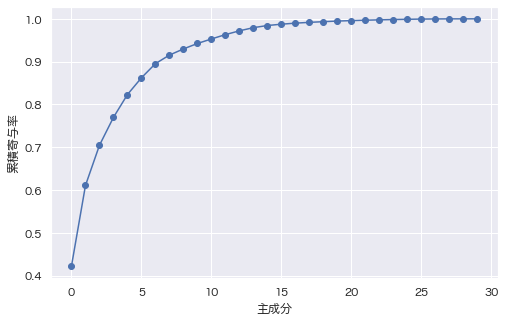

In [56]:
# 累積寄与率
contribution_ratio = pca.explained_variance_ratio_
accumulation_ratio = np.cumsum(contribution_ratio)
cc_ratio = np.hstack([0, accumulation_ratio])

plt.figure(figsize=[8,5])
plt.plot(accumulation_ratio, "-o")
plt.xlabel("主成分")
plt.ylabel("累積寄与率")
plt.grid()
plt.show();

In [57]:
contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
contribution_ratios.round(decimals=2).astype('str').head()
print(f"累積寄与率：　{contribution_ratios[contribution_ratios.index<5].sum().round(decimals=2).astype('str').values}")

,0
0,0.42
1,0.19
2,0.09
3,0.07
4,0.05


累積寄与率：　['0.82']


第5主成分で80%以上の累積寄与率

## 次元数2まで圧縮

説明分散比: [0.42297642 0.18809783]


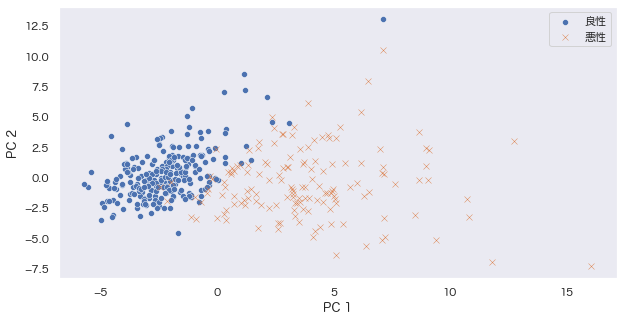

In [58]:
# PCA
# 次元数2まで圧縮
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
print(f'説明分散比: {pca.explained_variance_ratio_}')

# 散布図
temp2 = pd.DataFrame(X_train_pca)
temp2['目的変数'] = y_train.values
b = temp2[temp2['目的変数'] == 0]
m = temp2[temp2['目的変数'] == 1]
plt.figure(figsize=[10,5])
sns.scatterplot(x=b[0], y=b[1], marker='o', label='良性') # 良性
sns.scatterplot(x=m[0], y=m[1], marker='x', label='悪性') # 悪性
plt.xlabel('PC 1') # 第1主成分：x軸
plt.ylabel('PC 2') # 第2主成分：y軸
plt.legend();

In [59]:
dimensio_reduce2 = temp2.copy()
dimensio_reduce2.shape
dimensio_reduce2.head()

(398, 3)

,0,1,目的変数
0,-2,1,0
1,-4,1,0
2,-2,-0,0
3,0,-4,1
4,-5,3,0


第1・第2主成分は、説明分散比が高く（合計：61%）、よく分離できている。元データに対する説明力が高いことがわかる。

## 次元数5まで圧縮

説明分散比: [0.42297642 0.18809783 0.09377975 0.06510943 0.05332319]


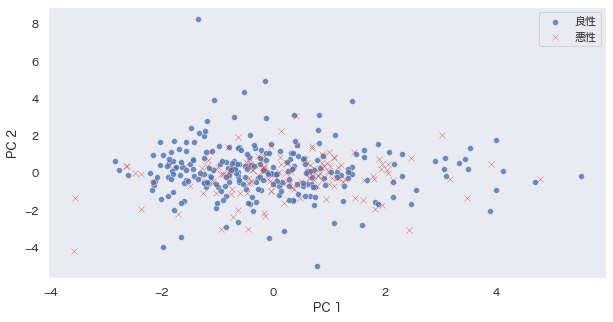

In [60]:
# PCA
pca = PCA(n_components=5, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
print(f'説明分散比: {pca.explained_variance_ratio_}')

# 散布図
temp5 = pd.DataFrame(X_train_pca)
temp5['目的変数'] = y_train.values
b = temp5[temp5['目的変数'] == 0]
m = temp5[temp5['目的変数'] == 1]
plt.figure(figsize=[10,5])
sns.scatterplot(x=b[3], y=b[4], marker='o', label='良性', alpha=0.8, color='b')
sns.scatterplot(x=m[3], y=m[4], marker='x', label='悪性', alpha=0.8, color='r')
plt.xlabel('PC 1') # 第1主成分：x軸
plt.ylabel('PC 2') # 第2主成分：y軸
plt.legend();

第4・第2主成分は、説明分散比が低く（合計：12%）、分離できていない。元データに対する説明力が低いことがわかる。

In [61]:
dimensio_reduce5 = temp5.copy()
dimensio_reduce5.shape
dimensio_reduce5.head()

(398, 6)

,0,1,2,3,4,目的変数
0,-2,1,-1,-1,0,0
1,-4,1,0,0,-1,0
2,-2,-0,-1,-0,-0,0
3,0,-4,-2,-0,1,1
4,-5,3,-0,-1,-3,0


# （再）学習

## 次元削減後のデータで学習

In [335]:
def learning(data):
    # 目的変数の抽出、データ分割
    X = data.drop('目的変数', axis=1)
    y = data['目的変数']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # 標準化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ロジスティック回帰
    model = LogisticRegressionCV(max_iter=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # 検証、評価
    print('訓練スコア: {:.3f}'.format(model.score(X_train_scaled, y_train)))
    print('テストスコア: {:.3f}'.format(model.score(X_test_scaled, y_test)))

    # 混同行列
    y_pred = model.predict(X_test_scaled)
    matrix = show_confusion_matrix(y_pred, y_test)
    matrix

    return model, X_train_scaled, y_train, matrix

訓練スコア: 0.958
テストスコア: 0.963


,予測_負例(0),予測_正例(1)
実際_負例(0),99,3
実際_正例(1),3,55


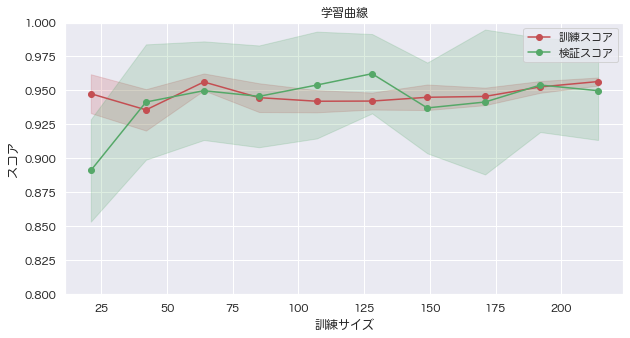

In [336]:
# 次元数2のデータで学習
model, X_train_scaled, y_train, matrix = learning(dimensio_reduce2)
matrix
plot_learning_curve(model, X_train_scaled, y_train)

訓練スコア: 0.979
テストスコア: 0.975


,予測_負例(0),予測_正例(1)
実際_負例(0),99,3
実際_正例(1),1,57


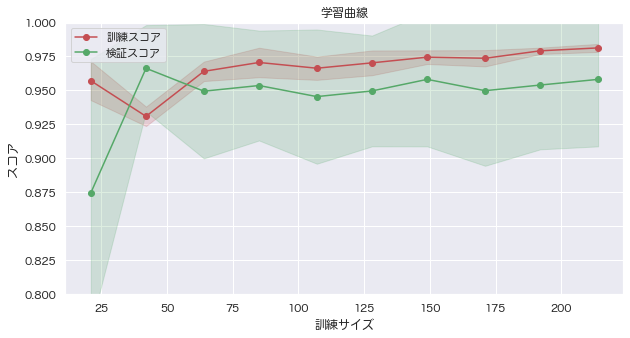

In [337]:
# 次元数5のデータで学習
model, X_train_scaled, y_train, matrix = learning(dimensio_reduce5)
matrix
plot_learning_curve(model, X_train_scaled, y_train)

精度の向上が見られる。  
訓練データと学習データのスコアの重なりは改善されている。  
やはりスコアが高すぎる気がする為、特徴量の精査は必要と思われる。  

## 交差検証

In [324]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

X = dimensio_reduce5.drop('目的変数', axis=1)
y = dimensio_reduce5['目的変数']

sk = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
predicts = []
aucs = []
y_tests = []
models = []
for train_index, test_index in tqdm(sk.split(X, y)):
    X_train_fld, X_test_fld = X.loc[train_index], X.loc[test_index]
    y_train_fld, y_test_fld = y.loc[train_index], y.loc[test_index]
    y_tests.append(y_test_loo)
    
    # ロジスティック回帰
    model = LogisticRegressionCV(cv=5,
                                    max_iter=1000,
                                    random_state=42,
                                    penalty='l2', # L2ノルム（正則化項）
                                    n_jobs=1)
    models.append(model)
    
    model.fit(X_train_fld, y_train_fld)
    pred = model.predict(X_test_fld)
    predicts.append(pred)
    
    matrix = show_confusion_matrix(pred, y_test_fld)
    matrix
    
    # 検証、評価
    fpr, tpr, thresholds = metrics.roc_curve(y_test_fld, pred)
    auc = metrics.auc(fpr, tpr)
    auc
    aucs.append(auc)

0it [00:00, ?it/s]

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=1, random_state=42)

,予測_負例(0),予測_正例(1)
実際_負例(0),50,0
実際_正例(1),2,28


0.9666666666666667

1it [00:00,  5.52it/s]

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=1, random_state=42)

,予測_負例(0),予測_正例(1)
実際_負例(0),50,0
実際_正例(1),2,28


0.9666666666666667

2it [00:00,  5.23it/s]

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=1, random_state=42)

,予測_負例(0),予測_正例(1)
実際_負例(0),48,2
実際_正例(1),0,30


0.98

3it [00:00,  4.94it/s]

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=1, random_state=42)

,予測_負例(0),予測_正例(1)
実際_負例(0),49,1
実際_正例(1),2,27


0.9555172413793103

4it [00:00,  5.05it/s]

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=1, random_state=42)

,予測_負例(0),予測_正例(1)
実際_負例(0),47,2
実際_正例(1),0,30


0.9795918367346939

5it [00:01,  4.57it/s]


In [325]:
# 検証、評価
np.mean(aucs, axis=0)

0.9696884822894674